In [1]:
import torch

torch.__version__

'2.9.1+cu130'

In [2]:
import requests
import os

def download_file(url, file_path, replace=False):
    # Construct the full path to the file
    full_path = os.path.join(file_path)

    # Check if the file already exists and remove it if necessary
    if os.path.exists(full_path):
        if not replace:
            print("file already exists")
            return
        os.remove(full_path)
        print(f"File {full_path} already exists. Replacing it.")

    try:
        # Download the file
        response = requests.get(url, allow_redirects=True)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Save the file
        with open(full_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved as {full_path}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# Example usage
url = 'https://raw.githubusercontent.com/amar-jay/karpathy/main/makemore/assets/names.txt'
file_path = os.path.join(os.getcwd(), "..", "..", "data", "baby_names.txt")

download_file(url, file_path)

file already exists


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline
g = torch.Generator().manual_seed(21012003) # for reproducibility

torch.__version__

with open(file_path, "r") as f:
    words = f.read().splitlines()
    words = [word.strip() for word in words] # get rid of any trailing spaces
    words = [w for w in words if w] # get rid of any empty strings
    names = sorted(words, key=lambda x: random.random())

min_chars = min(len(v) for v in names)
max_chars = max(len(v) for v in names)
chars = sorted(list(set("".join(names))))

# in replacement of the start and end token. Every name should end with a period. and there should be no start token to begin a sequence
chars = ['.'] + chars
chars_count = len(chars)
print("names: ", names[:5])
print("number of names: ", len(names))
print("(list of chars, count): ", ("".join(chars), chars_count))
print("(max word length, min word length): ", (max_chars, min_chars))

atoi = {ch:i for i,ch in enumerate(chars)}
itoa = {i:ch for i,ch in enumerate(chars)}

# adding end token to each name
names = [list(name) + ['.'] for name in names]

names:  ['tyr', 'nissa', 'cade', 'athulya', 'thais']
number of names:  32033
(list of chars, count):  ('.abcdefghijklmnopqrstuvwxyz', 27)
(max word length, min word length):  (15, 2)


In [4]:
# hyper-params
n_embd = 10  # intermediate weight size
block_size  = 3 # context length
n_embd2 = 200 # intermediate weight size
lr = 0.05 # determined based on graph
decay_rate = 0.01 # learning rate decay
batch_size = 64

In [5]:
# build_dset basically builds a rolling window on the dataset based on the context length.
def get_dataset(dset, ctxt_len):
    X, Y = [], []
    for name in dset:
        context  = [0] * ctxt_len
        for ch in name:
            ix = atoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itoa[i] for i in context), '--->', itoa[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
    
# train-test split(80, 10, 10)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X_train, Y_train = get_dataset(names[:n1], block_size)
X_val, Y_val = get_dataset(names[n1:n2], block_size)
X_test, Y_test = get_dataset(names[n2:], block_size)

for c, d in zip(X_train[:5], Y_train[:5]):
    print(''.join(itoa[i.item()] for i in c), "=>", itoa[d.item()])

... => t
..t => y
.ty => r
tyr => .
... => n


In [6]:
# (EXP 1) TRAINING WITHOUT BATCH NORM
# parameters
C_ = torch.randn((27, n_embd), generator=g) 
W1_ = torch.randn((block_size * n_embd, n_embd2), generator=g) # hidden layer
b1_ = torch.randn(n_embd2, generator=g)
W2_ = torch.randn((n_embd2, 27), generator=g) # output layer
b2_ = torch.zeros(27,)

params_ = [C_, W1_, b1_, W2_, b2_]

for p in params_:
    p.requires_grad = True # autograd should record operations
    
max_steps = 100000
losses_ = []

for i in range(max_steps):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb_ = C_[X_train[ix]].view(-1, block_size * n_embd)
    v_ = emb_ @ W1_ + b1_
    v1 = v_

    h_ = torch.tanh(v_) # intermediate layer
    logits = h_ @ W2_ + b2_
        
    loss_ = F.cross_entropy(logits, Y_train[ix])
    if i % 10000 == 0:
        print("(", (i * 100) / max_steps , "%) loss =", loss_.item())
    
    # backward pass
    for p in params_:
        p.grad = None
    loss_.backward()

    # update
    lri_ = lr if max_steps > 10000 else decay_rate
    for p in params_:
        p.data += - lri_ * p.grad 
    losses_.append(loss_.item())

( 0.0 %) loss = 28.945266723632812
( 10.0 %) loss = 2.2817747592926025
( 20.0 %) loss = 2.413281202316284
( 30.0 %) loss = 2.0108001232147217
( 40.0 %) loss = 2.0633609294891357
( 50.0 %) loss = 2.131596565246582
( 60.0 %) loss = 2.4070260524749756
( 70.0 %) loss = 2.4280195236206055
( 80.0 %) loss = 2.1242291927337646
( 90.0 %) loss = 2.5042402744293213


In [7]:
# (EXP 2) TRAINING WITH BATCH NORM WITH STATIC STATES

# parameters
C = torch.randn((27, n_embd), generator=g) 
W1 = torch.randn((block_size * n_embd, n_embd2), generator=g) # hidden layer
b1 = torch.randn(n_embd2, generator=g) * 0.01
W2 = torch.randn((n_embd2, 27), generator=g) * 0.01 # output layer
b2 = torch.zeros(27,)


# kaiming initialization
gain = 5/3 # for tanh
fan_in = block_size * n_embd # the number of input units for a weight matrix 

W1 *= ((5/3)/(fan_in**0.5)) 

#buffers
bn_gain = torch.ones((1, n_embd2))
bn_bias = torch.zeros((1, n_embd2))

params = [C, W1, b1, W2, b2, bn_gain, bn_bias] # batchnorm gain and bias are trainable params

for p in params:
    p.requires_grad = True # autograd should record operations
    
max_steps = 100000
losses = []

for i in range(max_steps):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb = C[X_train[ix]].view(-1, block_size * n_embd)
    v = emb @ W1 + b1
    v2 = v

    # batch norm
    # as the size of v params increases, the net mean and var remain consistent across iterations
    mean = v.mean(dim=0, keepdim=True)
    var = v.var(dim=0, keepdim=True)
    pre_tanh = (v - mean) / (var + 1e-5).sqrt()
    pre_tanh = bn_gain * pre_tanh + bn_bias

    h = torch.tanh(pre_tanh) # intermediate layer
    logits = h @ W2 + b2
        
    loss = F.cross_entropy(logits, Y_train[ix])
    if i % 10000 == 0:
        print("(", (i * 100) / max_steps , "%) loss =", loss.item())
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lri = lr if max_steps > 10000 else decay_rate
    for p in params:
        p.data += - lri * p.grad 
    losses.append(loss.item())

with torch.no_grad():
	plt.title("Loss vs. Iterations")
	plt.plot(losses)

( 0.0 %) loss = 3.311758279800415
( 10.0 %) loss = 2.142641067504883
( 20.0 %) loss = 2.25516676902771
( 30.0 %) loss = 2.2624003887176514
( 40.0 %) loss = 1.847599983215332
( 50.0 %) loss = 1.9414587020874023
( 60.0 %) loss = 2.0193309783935547
( 70.0 %) loss = 2.1193723678588867
( 80.0 %) loss = 2.039311408996582
( 90.0 %) loss = 1.9171650409698486


In [8]:
# (EXP 3) TRAINING WITH BATCH NORM WITH RUNNING STATE 
# in running state, params are not trainable params, the mean and var are computed on the fly 
# mean = (1 - momentum) * mean + momentum * mean
 
# parameters
C = torch.randn((27, n_embd), generator=g) 
W1 = torch.randn((block_size * n_embd, n_embd2), generator=g) # hidden layer
b1 = torch.randn(n_embd2, generator=g) * 0.01
W2 = torch.randn((n_embd2, 27), generator=g) * 0.01 # output layer
b2 = torch.zeros(27,)

# kaiming initialization
gain = 5/3 # for tanh
fan_in = block_size * n_embd # the number of input units for a weight matrix 

W1 *= ((5/3)/(fan_in**0.5)) 

#buffers
bn_gain = torch.ones((1, n_embd2)) 
bn_bias = torch.zeros((1, n_embd2))

#buffers
running_bn_mean = torch.ones((1, n_embd2)) # running mean
running_bn_var = torch.zeros((1, n_embd2)) # running variance
momentum = 0.1 # discount rate of running params across iteration

params = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in params:
    p.requires_grad = True # autograd should record operations
    
max_steps = 100000
losses = []

for i in range(max_steps):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb = C[X_train[ix]].view(-1, block_size * n_embd)
    v = emb @ W1 + b1
    v3 = v

    # batch norm
    mean = v.mean(dim=0, keepdim=True)
    var = v.var(dim=0, keepdim=True, unbiased=False)

    # update running statistics ONLY DURING TRAINING
    running_bn_mean = (1 - momentum) * running_bn_mean + momentum * mean          
    running_bn_var = (1 - momentum) * running_bn_var + momentum * var
    # the running bn mean and var are used in place of the mean and var during inference.
    
    pre_tanh = (v - mean) / (var + 1e-5).sqrt()
    pre_tanh = bn_gain * pre_tanh + bn_bias

    h = torch.tanh(pre_tanh) # intermediate layer
    logits = h @ W2 + b2
        
    loss = F.cross_entropy(logits, Y_train[ix])
    if i % 10000 == 0:
        print("(", (i * 100) / max_steps , "%) loss =", loss.item())
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lri = lr if max_steps > 10000 else decay_rate
    for p in params:
        p.data += - lri * p.grad 
    losses.append(loss.item())

with torch.no_grad():
	plt.title("Loss vs. Iterations")
	plt.plot(losses)

( 0.0 %) loss = 3.3202435970306396
( 10.0 %) loss = 2.0910768508911133
( 20.0 %) loss = 2.1348674297332764
( 30.0 %) loss = 2.022808074951172
( 40.0 %) loss = 2.2041640281677246
( 50.0 %) loss = 2.4441590309143066
( 60.0 %) loss = 2.124042272567749
( 70.0 %) loss = 2.076044797897339
( 80.0 %) loss = 2.0883705615997314
( 90.0 %) loss = 1.9758107662200928


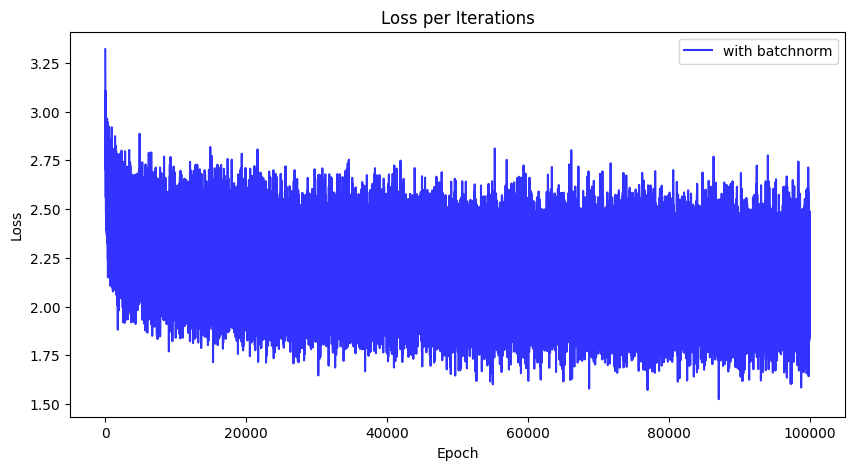

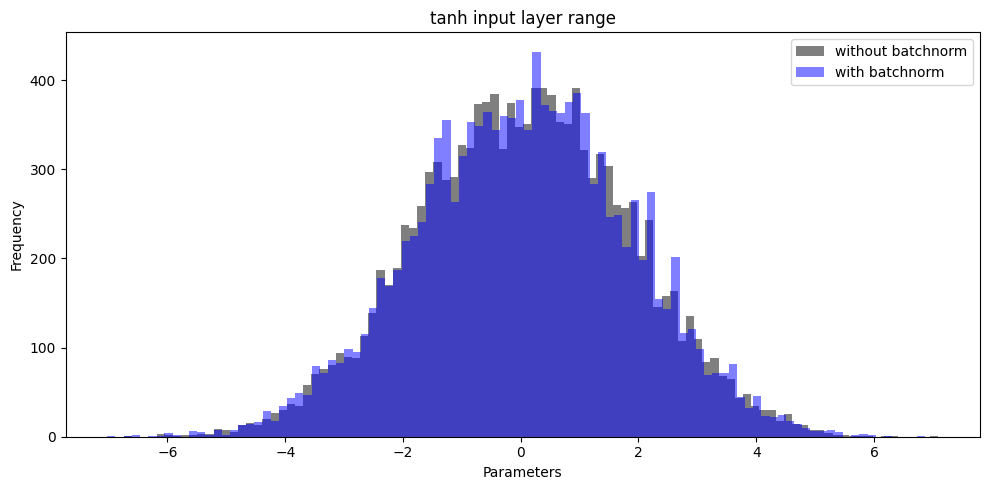

In [9]:
# visualize weight and cross checking vanishing or exploding gradients.
assert None not in [C, W1, b1, W2, b2] , "need to run EXP to make weights available" 


ix = torch.randint(0, X_train.shape[0], (batch_size,))

# forward pass
emb = C[X_train[ix]].view(-1, block_size * n_embd)
v = emb @ W1 + b1

# batch norm
# use running mean and var
mean = running_bn_mean          
var = running_bn_var
# the running bn mean and var are used in place of the mean and var during inference.
    
pre_tanh = (v - mean) / (var + 1e-5).sqrt()
pre_tanh = bn_gain * pre_tanh + bn_bias

h = torch.tanh(pre_tanh) # intermediate layer
logits = h @ W2 + b2
        
loss = F.cross_entropy(logits, Y_train[ix])
if i % 10000 == 0:
    print("(", (i * 100) / max_steps , "%) loss =", loss.item())
    

with torch.no_grad():
    # Plot the graphs
    # basically gradient descent is equal in training. However parameter distribution varies. There's exploding and vanishing gradients in unnormalized one
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='with batchnorm', alpha=0.8,  color='blue',)
    plt.title("Loss per Iterations")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.hist(v3.view(-1), bins=100, alpha=0.5, label='without batchnorm', color="black")
    plt.hist(v.view(-1), bins=100, alpha=0.5, label='with batchnorm', color="blue")

    plt.title("tanh input layer range")
    plt.xlabel('Parameters')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
@torch.no_grad()
def loss(x, y, _params):
    emb = _params[0][x].view(-1, 30)
    v = emb @ _params[1] + _params[2]
    h = torch.tanh(v) # intermediate layer
    logits = h @ _params[3] + _params[4]
    loss = F.cross_entropy(logits, y)
    return loss.item()

print("With normalization")
params = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print("training loss: ", loss(X_train, Y_train, params))
print("val loss: ", loss(X_val, Y_val, params))
print("test loss: ", loss(X_test, Y_test, params))
print("-"*8)

With normalization
training loss:  2.6319823265075684
val loss:  2.6591813564300537
test loss:  2.6518068313598633
--------


In [11]:
# inference its totally unneccessary but I thought it might be cool to add
import time

# not sure if this is the right way to do it
@torch.no_grad()
def nnl(name):
    "to calculate the likelihood of a word in a mlp model"
    x, y = get_dataset([name], block_size)
    emb = C[x]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss


with torch.no_grad():
    generated_names = []
    print("generating...")
    start_time = time.time()
    while True:
        out = []
        probs = None
        context  = [0] * block_size
        while True:
            emb = C[torch.tensor(context)].view(-1, block_size * n_embd)
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            # print(probs)
            ix = torch.multinomial(probs, num_samples=1, generator=g)
            context = context[1:] + [ix]
            out.append(ix)
            
            if ix == 0:
                break

        word = ''.join(itoa[i.item()] for i in out)
        if nnl(word) < 1.5 and len(word) > 3 and word not in generated_names:
            print("+ valid word: ", word)
            generated_names.append(word) 
        if len(generated_names) == 10:
            break
    duration = time.time() - start_time
    print("duration: ", duration)


generating...
+ valid word:  jazlya.
+ valid word:  thidan.
+ valid word:  ellanny.
+ valid word:  hanilan.
+ valid word:  malanna.
+ valid word:  anal.
+ valid word:  mylannaq.
+ valid word:  jovanah.
+ valid word:  anna.
+ valid word:  dakleslivannaquintlynn.
duration:  1.001344919204712


In [ ]:
# batch norm 2d is applied to 4 dimensional inputs.
# batchnorm 2d is similar to batch norm 1d (the above implementation)
# the only difference is in batch norm 1d mean is computed as
# mean1d = mean(dim=0) but mean2d = mean(dim=(0, 2, 3))
# the same applies to variance.

# secondly, what does unbiased parameter in variance mean? and why is it used?
# First, grounding: “unbiased” refers to Bessel’s correction.
# in classical statistics, unbiased is used. such that var = sum(x - mean) / (N - 1)
# however in biased/ maximum likelihood scenario, var = sum(x - mean) / N
# because BatchNorm is not doing statistical inference, it is doing numerical normalization inside an optimization loop. biased (N) is used